In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from textwrap import fill

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Make Simulator and Training Data
cs_name_val = 1
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 5

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
print(simulator.noise_std)
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)
val_data = simulator.gen_sim_data(15, 15, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, simulator.seed, False)
# print(sim_data.theta_vals)
all_gp_data = sim_data
all_val_data = val_data

0.09972314379508178


In [30]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

retrain_GP = 5
normalize = True
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel

#Get GP object
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)
#Train on all sets
train_data, test_data = gp_object.set_train_test_data(1.0, seed)
new_gp_model = gp_object.set_gp_model()
gp_object.train_gp(new_gp_model)

#Create a Data Class which is Sim and Val Data together
t_train_val = np.concatenate((sim_data.theta_vals, val_data.theta_vals))
x_train_val = np.concatenate((sim_data.x_vals, val_data.x_vals))
y_train_val = np.concatenate((sim_data.y_vals, val_data.y_vals))

all_data = Data(t_train_val, x_train_val, y_train_val, None, None, None, None, None, 
all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

X = gp_object.featurize_data(all_data)
y = all_data.y_vals
n_samples = len(all_data.y_vals)

# X = gp_object.featurize_data(all_gp_data)
# y = all_gp_data.y_vals
# n_samples = len(all_gp_data.y_vals)

predict_mean = []
predict_std = []
train_mean = []
train_std = []


#For each sample in the full set
for i in range(n_samples):
    #Get sample Data
    t_leave_one = np.atleast_2d(all_data.theta_vals[i])
    X_leave_one = np.atleast_2d(all_data.x_vals[i])
    y_leave_one = np.atleast_2d(all_data.y_vals[i])
    t_rest = np.delete(all_data.theta_vals,i,axis=0)
    X_rest = np.delete(all_data.x_vals,i,axis=0)
    y_rest = np.delete(all_data.y_vals,i,axis=0)
    loo_data = Data(t_leave_one, X_leave_one, y_leave_one, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    feat_loo = gp_object.featurize_data(loo_data)

    is_row_train = np.any(np.all(gp_object.feature_train_data == feat_loo, axis=1))
    if is_row_train:
        j = np.where(is_row_train == True)
        # Remove the ignored point from the kernel matrix
        t_train = np.delete(train_data.theta_vals,j,axis=0)
        X_train = np.delete(train_data.x_vals,j,axis=0)
        y_train = np.delete(train_data.y_vals,j,axis=0)

        new_train = Data(t_train, X_train, y_train, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

        feat_new_train = gp_object.featurize_data(new_train)
        # old_alpha = gp_object.fit_gp_model.alpha_
        # new_alpha = np.delete(old_alpha, j, axis=0)
        # old_L = gp_object.fit_gp_model.L_
        # new_L = np.delete(np.delete(old_L, j, axis=0), j, axis=1)
        
        # new_gp = copy.deepcopy(gp_object)
        # new_gp.fit_gp_model.X_train_ = feat_new_train
        # new_gp.fit_gp_model.y_train_ = y_train.reshape(-1,1)
        # new_gp.fit_gp_model.L_ = new_L
        # new_gp.fit_gp_model.alpha_ = new_alpha
        # print(new_gp.fit_gp_model.X_train_.shape, new_gp.fit_gp_model.y_train_.shape, new_gp.fit_gp_model.L_.shape, new_gp.fit_gp_model.alpha_.shape)
        y_train_modified = np.delete(y_train, j)
        y_pred = gp_object.fit_gp_model.predict(feat_new_train)
        y_pred_modified = np.delete(y_pred, j)  
        y_loo_mean, y_loo_var = new_gp.eval_gp_mean_var_misc(loo_data, feat_loo, covar = False)
        y_loo_std =  np.sqrt(y_loo_var)
        print(y_pred, y_pred_modified)
    else:
        new_gp = gp_object
        # print(new_gp.fit_gp_model.X_train_.shape, new_gp.fit_gp_model.y_train_.shape, new_gp.fit_gp_model.L_.shape, new_gp.fit_gp_model.alpha_.shape)


    #Get mean and variance
    # y_loo_mean, y_loo_var = new_gp.eval_gp_mean_var_misc(loo_data, feat_loo, covar = False)
    # y_loo_std =  np.sqrt(y_loo_var)


    #Check for feat_loo in train and test feat
    
    if is_row_train:
        train_mean.append(float(y_loo_mean))
        train_std.append(float(y_loo_std))
    else:
        predict_mean.append(float(y_loo_mean))
        predict_std.append(float(y_loo_std))

    # t_leave_one = np.atleast_2d(all_gp_data.theta_vals[i])
    # X_leave_one = np.atleast_2d(all_gp_data.x_vals[i])
    # y_leave_one = np.atleast_2d(all_gp_data.y_vals[i])
    # t_rest = np.delete(all_gp_data.theta_vals,i,axis=0)
    # X_rest = np.delete(all_gp_data.x_vals,i,axis=0)
    # y_rest = np.delete(all_gp_data.y_vals,i,axis=0)

    # test_data = Data(t_leave_one, X_leave_one, y_leave_one, None, None, None, None, None, 
    #                         all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

    # train_data = Data(t_rest, X_rest, y_rest, None, None, None, None, None, 
    #                         all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

    # gp_object.train_data = train_data
    # gp_object.test_data = test_data
    # #Set training and validation data features in GP_Emulator base class
    # ft_train= gp_object.featurize_data(gp_object.train_data)
    # ft_test = gp_object.featurize_data(gp_object.test_data)
    # gp_object.feature_train_data  = ft_train
    # gp_object.feature_test_data = ft_test

    # gp_object.train_data_init = ft_train
    # #fit GP model
    # # Scaling before fitting is automatic
    # new_gp_model = gp_object.set_gp_model()
    # gp_object.train_gp(new_gp_model)

    # #get mean, variance
    # feat_val = gp_object.featurize_data(all_val_data)
    # y_train_mean, y_train_var = gp_object.eval_gp_mean_var_misc(train_data, ft_train, covar = False)
    # y_test_mean, y_test_var = gp_object.eval_gp_mean_var_test(covar = False)
    
    # #inverse transform predicted result
    # y_train_std = np.sqrt(y_train_var)
    # y_test_std =  np.sqrt(y_test_var)

    # #record result
    # predict_mean.append(float(y_test_mean))
    # predict_std.append(float(y_test_std))
    # train_mean.append(y_train_mean)
    # train_std.append(y_train_std)

[ 4.94984969e-01  4.33919308e-02  2.39883827e+00  2.49529058e+00
 -3.79787429e+00 -4.25871000e+00 -7.02153693e-02 -3.64409092e-01
  3.79204516e-01 -1.80098391e+00 -1.51729948e+00  1.73499474e-02
  4.21154945e+00  3.47929827e+00 -2.29348531e+00 -1.67708334e+00
  1.65800922e-02 -5.85499940e-01  4.51004477e-01 -3.04787240e+00
 -3.20675458e+00  5.62759440e-02  1.70840593e+00  1.80399241e+00
 -2.31741525e+00 -2.06171766e+00  3.24913460e-03  2.49362726e+00
  2.42742728e+00 -1.27159514e+00 -7.01543971e-01  3.24589878e-02
  4.70014192e+00  3.82712929e+00 -2.29875080e+00 -1.82161485e+00
  4.33895431e-02  1.13891925e+00  1.58468290e+00 -1.02697017e+00
  2.51404682e-01  3.01324708e-03  1.30229588e+00  1.75717870e+00
 -2.97243564e+00 -2.81295500e+00  4.88901123e-02 -5.36497249e-01
  4.25790135e-01 -2.35358582e+00 -2.34738486e+00  3.29250596e-02
  3.53109804e+00  2.99423713e+00 -2.55420446e+00 -2.09677313e+00
  5.12106139e-02 -1.76843417e+00 -3.76075784e-01 -5.01886101e-01
  9.78276706e-01  8.27608

In [31]:
R2_score = r2_score(val_data.y_vals, predict_mean)
# R2_score = r2_score(y, predict_mean)
print(predict_mean)
print(predict_std)
print(R2_score)

[0.1916586268488814, -14.449106476253501, -0.18103211361113863, 0.14615917372130527, 3.616546484608901, -3.3227511282879902, -8.293008986007505, -0.22688048054633442, -1.3017715504839062, 0.463458164856556, -0.2870275181276341, -10.969244418233457, 1.1418415947773557, 1.7714899524922512, 4.653136569536885, 0.8672311653210625, -0.835680511180309, -0.9238355977190571, 0.36505932730912666, 6.007602186067166, 1.6871926947787252, 0.8696823555478762, -0.749560739418364, 1.8778243257365708, -0.06530186741341015, 1.7170013993998319, 0.33169798442869175, 1.105731293217546, 2.3099373604961646, 7.869647580374454, 0.29874453750389496, -2.6452619562044806, 0.47986618288423444, 0.10533469399436197, 12.637045627944138, -0.10868315072405224, -1.1540090845287436, -0.1711508003779736, 0.34326362627268786, 2.407093960628544, 0.5103871399887072, -1.6862638961358383, 4.53662863513963, 6.621096419072338, 15.26166197502358, 0.5482941419728952, -5.541678323770045, -0.6732753019994918, 0.25419921096532044, 5.9

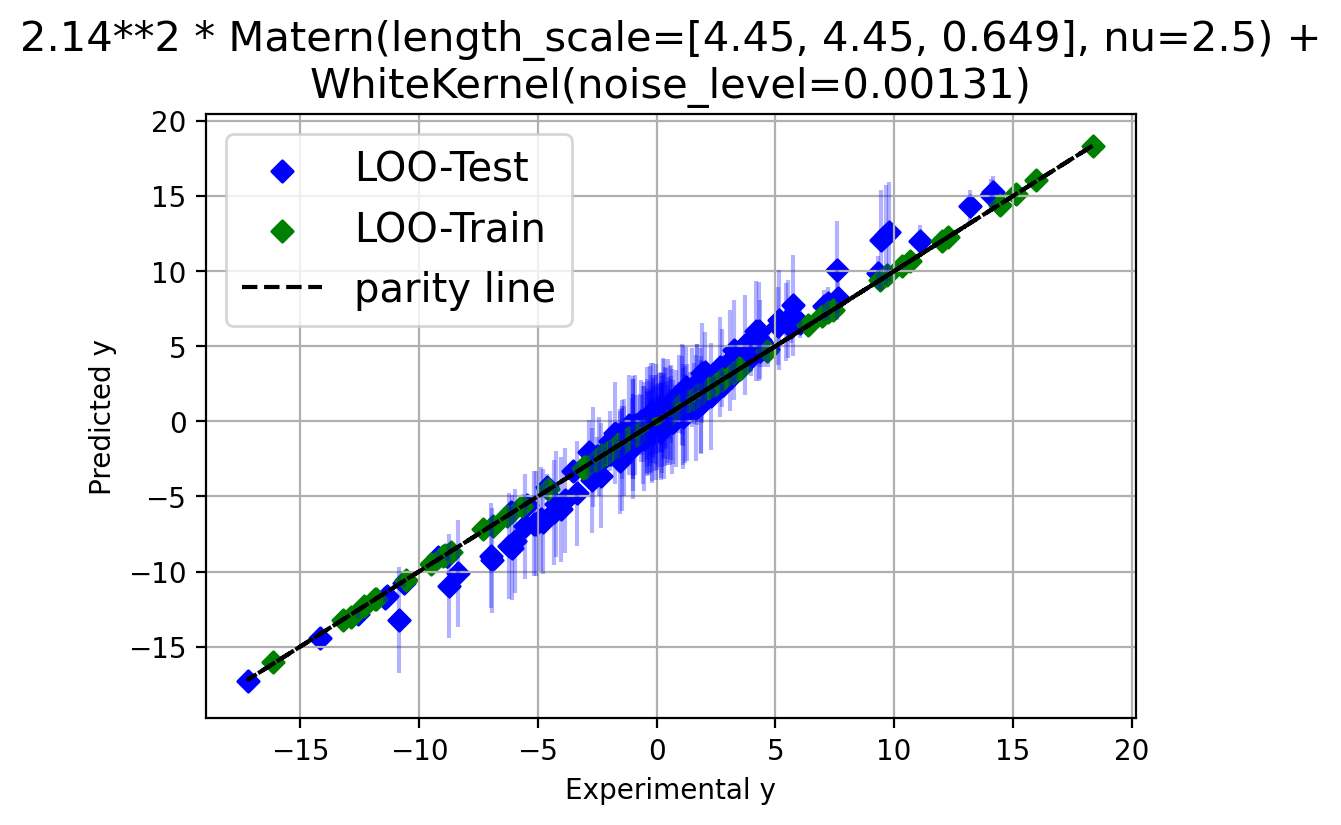

In [32]:
text = 'LOO-$R^2$ score: ' + str(np.round(R2_score,2))

# plt.scatter(y, predict_mean, 30,c='b', marker='D', label='LOO-Test')
# plt.errorbar(y, predict_mean, 1.96*np.array(predict_std), c='b', fmt = ' ', alpha = 0.3)
plt.scatter(val_data.y_vals, predict_mean, 30,c='b', marker='D', label='LOO-Test')
plt.errorbar(val_data.y_vals, predict_mean, 1.96*np.array(predict_std), c='b', fmt = ' ', alpha = 0.3)
plt.scatter(sim_data.y_vals, train_mean, 30,c='g', marker='D', label='LOO-Train')
plt.errorbar(sim_data.y_vals, train_mean, 1.96*np.array(train_std), c='g', fmt = ' ', alpha = 0.3)

plt.plot(y,y,'k--', label='parity line')
plt.xlabel('Experimental y')
plt.ylabel('Predicted y')
plt.title(fill(str(gp_object.fit_gp_model.kernel_), 60), fontdict={'size':15})
plt.grid(True)
plt.legend(fontsize='x-large')
# plt.text(1500, 100, text)
# plt.text(1000, 0, '*Error Bars are 1.96 Standard Deviation')
# plt.savefig('pic_Loo_R2_score')
plt.show()